##  요청 사항
* IndySDK 설치 요청
* 스펀지 더 말랑말랑 하게

## Info
* 192.168.0.10 pw:kiro0209

## 추가구현
### TBD
#### 동작
* local map 적용
    * SharedMemoryHost, SharedMemoryClient 구현
    * 주기적 맵 리더 구현
    * 맵 픽셀들 충돌 안함, 이상
    * approach through 발생 안함, 뭔가 이상
* 세로 닦기로 전략 변경
    * 끝단에서만 위치 보정하기
* bed 영역 최대한 맞추기 - 다리쪽 10cm 정도 추가
* 추가요소
    * ros로 모바일 로봇 제어하기 - KiroMobileClient 구현 - 메시지 타입 요청
  
#### 인식
* full view 인식할 때 벽 피팅
* front ICP 체크 필요 - closet 확인
* ICP 모듈화 후 느려짐 - 속도 분석 및 최적화

### DONE
#### 동작
* reach data 수집 시 모바일 베이스 위에서 수집, 모바일 앞쪽 충돌 경계랑 베드 높이랑 맞춰서 수집해놓기 v
* 닦기 순서 바꾸기 - 옷장 -> 베드 v
* 스케줄간 동작 연결 v
* 물체 방향 따라 근접샷 자세 잡기 v
* 중간 감지 결과 따라 로봇을 움직이기 - 병합/실험 시 적용 v
* 현장에서 플래닝시 오래 멈춤 - 멀티프로세스 중단 딜레이, 원인 파악 불가? x
* 최대한 안움직이고 닦기 + 동작 간 연결하기 v
* KiroMobileRobot 클래스화 v
* 침대 닦을때 옷장 보고 닦기 v
* view motion 다른 com link 경우 수정 필요 v
* 스크립트 정리 v
* safe waypoint 구현 v
* v tool offset 여유있게 + 모바일 로봇으로 밀어서 닦기
* 베이스 조정 전 동작 업데이트 시도 - 각도 빼고 위치만 v
* ros로 맵 정보 얻기 - 목표점 충돌 가능성 확인 필요
  - master를 ip 통한 방법 숙지 v
  - 10/25 현장에서 데이터 받아올 것 v
  - 플래닝 프레임워크에 맵 정보 추가 구현하기 (map_data.pkl, cost_data.pkl 참고) v
  

#### 인식
* 정면 인식 불확실성 해결 v
  - 제일 가까운 포인트를 침대 다리부분으로 가정, 바닥 각도만 맞춰서 초기화 하고 ICP 시도 + 기본 ICP 해서 더 잘 맞은 쪽 선택하기 시도
* 옷장 근접 인식 - 부분 피팅 + 방향 에러 -> 위치 에러
  - 찍힌 부분 중심 Transformation v
  - 스캔 다 해서 피팅 x
* 물체 간 관계 모순 발생 -> full view 추가해서 해결
* 추가 요소
  * 전체 환경 reconsruction에 촬영 이미지를 추가 + 현재 위치 맞추는 방식 - drop
    - 한 요소 이동 방식으로는 두 요소간 위치 관계 반영 안됨 (한개 중심으로 맞추면 다른게 틀어짐)
    - 옷장 닦다가 침대 충돌, 해결 필요
* multi ICP module v
* 지오메트리 기반 point in/out v

## ROS TCP/IP 연동 

### IP setting
#### Master
```bash
export ROS_IP={master-ip}
export ROS_MASTER_URI=http://localhost:11311
export ROS_HOSTNAME=$ROS_IP
```  
#### Slave 
```bash
export ROS_MASTER_URI=http://{master-ip}:11311
export ROS_HOSTNAME={slave-ip}
```

In [1]:
Packet_data=tuple((4.71,  1.72, -0.71,  0.71))+tuple((0,))

In [11]:
udp_send_data = struct.pack('>ffffi',*Packet_data)

In [15]:
import socket
from demo_utils.kiro_udp_send import start_mobile_udp_thread, send_pose_wait, get_xyzw_cur, get_reach_state, UDP_PORT_SEND, struct, UDP_PORT_RECV, RECV_UDP_IP

In [18]:
recv_ip = "192.168.0.8"

In [19]:
sock = socket.socket(socket.AF_INET, socket.SOCK_DGRAM) # UDP
sock.setsockopt(socket.SOL_SOCKET, socket.SO_REUSEADDR, 1)
sock.bind((recv_ip, UDP_PORT_RECV))

In [20]:
send_ip = "192.168.0.102"

sock.sendto(udp_send_data,(send_ip, UDP_PORT_SEND))

20

ImportError: cannot import name Packet_data

### Check topics

In [1]:
!rostopic list -v


Published topics:
 * /map_metadata [nav_msgs/MapMetaData] 1 publisher
 * /move_base/global_costmap/costmap_updates [map_msgs/OccupancyGridUpdate] 1 publisher
 * /amcl_pose [geometry_msgs/PoseWithCovarianceStamped] 1 publisher
 * /move_base/current_goal [geometry_msgs/PoseStamped] 1 publisher
 * /scan2 [sensor_msgs/LaserScan] 1 publisher
 * /velodyne_nodelet_manager_cloud/parameter_descriptions [dynamic_reconfigure/ConfigDescription] 1 publisher
 * /move_base/local_costmap/inflation_layer/parameter_descriptions [dynamic_reconfigure/ConfigDescription] 1 publisher
 * /velodyne_nodelet_manager_driver/parameter_updates [dynamic_reconfigure/Config] 1 publisher
 * /move_base/global_costmap/parameter_updates [dynamic_reconfigure/Config] 1 publisher
 * /rosout_agg [rosgraph_msgs/Log] 1 publisher
 * /clicked_point [geometry_msgs/PointStamped] 1 publisher
 * /move_base/local_costmap/costmap [nav_msgs/OccupancyGrid] 1 publisher
 * /odom [nav_msgs/Odometry] 1 publisher
 * /move_base/global_costmap

### Listener script

In [35]:
import rospy
from sensor_msgs.msg import JointState
from std_msgs.msg import String
from nav_msgs.msg import OccupancyGrid
NODE_NAME = "listen_tester"
rospy.init_node(NODE_NAME, anonymous=True)
    
class Listener:
    
    def __init__(self, topic_name, topic_type):
        self.topic_name, self.topic_type = topic_name, topic_type
        self.data_stack = []

    def callback(self, data):
        rospy.loginfo(rospy.get_caller_id() + "I heard %s", data.data)
        self.data_stack.append(data)
        
    def get_data(self, timeout=5):
        return rospy.wait_for_message(self.topic_name, self.topic_type, 
                                      timeout=timeout)

    ##
    # @brief spin() simply keeps python from exiting until this node is stopped
    def spin(self):
        rospy.Subscriber(self.topic_name, self.topic_type, self.callback)
        rospy.spin()    

In [36]:
map_listener = Listener(topic_name="/map", topic_type=OccupancyGrid)
cost_listener = Listener(topic_name="/move_base/global_costmap/costmap", topic_type=OccupancyGrid)

In [37]:
map_data = map_listener.get_data()
cost_data = cost_listener.get_data()

In [44]:
import numpy as np
import cv2

In [45]:
import os
import sys
sys.path.append(os.path.join(os.path.join(os.environ["RNB_PLANNING_DIR"], 'src')))

In [46]:
from pkg.utils.utils import *

In [59]:
def convert_map_cm(map_data):
    map_size = (map_data.info.height, map_data.info.width)
    map_im = (np.reshape(map_data.data, map_size)+1).astype(np.uint8)
    res_ratio = map_data.info.resolution / 0.01
    map_im_cm = cv2.resize(map_im, dsize=None, fx=res_ratio, fy=res_ratio)
    return map_im_cm

In [60]:
bin_map = convert_map_cm(map_data)

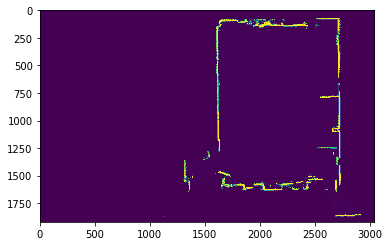

In [61]:
plt.imshow(bin_map)

In [62]:
cost_map = convert_map_cm(cost_data)

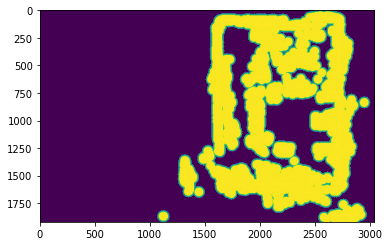

In [63]:
plt.imshow(cost_map)

In [65]:
save_pickle(os.path.join(os.environ["RNB_PLANNING_DIR"],"data/map_data.pkl"), map_data)
save_pickle(os.path.join(os.environ["RNB_PLANNING_DIR"],"data/cost_data.pkl"), cost_data)